# Location Dataset: Analysis - Model Training - Model Evalutaion

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
from pandas_profiling import ProfileReport
from pandas.api.types import CategoricalDtype
from scipy.io import arff
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score
plt.style.use('seaborn-whitegrid')
%matplotlib inline

np.random.seed(42)



def load_preprocessed_bankruptcy(scale=True, splitXY=True):
    # def assign_variable_names(unnamed_data):
    arff_data = arff.loadarff('../data/polish_companies_bankruptcy/5year.arff')
    ds = pd.DataFrame(arff_data[0])
    variable_names = ["net profit / total assets",
                      "total liabilities / total assets",
                      "working capital / total assets",
                      "current assets / short - term liabilities",
                      "[(cash + short - term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
                      "retained earnings / total assets",
                      "EBIT / total assets",
                      "book value of equity / total liabilities",
                      "sales / total assets",
                      "equity / total assets",
                      "(gross profit + extraordinary items + financial expenses) / total assets",
                      "gross profit / short - term liabilities",
                      "(gross profit + depreciation) / sales",
                      "(gross profit + interest) / total assets",
                      "(total liabilities * 365) / (gross profit + depreciation)",
                      "(gross profit + depreciation) / total liabilities",
                      "total assets / total liabilities",
                      "gross profit / total assets",
                      "gross profit / sales",
                      "(inventory * 365) / sales",
                      "sales(n) / sales(n - 1)",
                      "profit on operating activities / total assets",
                      "net profit / sales",
                      "gross profit( in 3 years) / total assets",
                      "(equity - share capital) / total assets",
                      "(net profit + depreciation) / total liabilities",
                      "profit on operating activities / financial expenses",
                      "working capital / fixed assets",
                      "logarithm of total assets",
                      "(total liabilities - cash) / sales",
                      "(gross profit + interest) / sales",
                      "(current liabilities * 365) / cost of products sold",
                      "operating expenses / short - term liabilities",
                      "operating expenses / total liabilities",
                      "profit on sales / total assets",
                      "total sales / total assets",
                      "(current assets - inventories) / long - term liabilities",
                      "constant capital / total assets",
                      "profit on sales / sales",
                      "(current assets - inventory - receivables) / short - term liabilities",
                      "total liabilities / ((profit on operating activities + depreciation) * (12 / 365))",
                      "profit on operating activities / sales",
                      "rotation receivables + inventory turnover in days",
                      "(receivables * 365) / sales",
                      "net profit / inventory",
                      "(current assets - inventory) / short - term liabilities",
                      "(inventory * 365) / cost of products sold",
                      "EBITDA(profit on operating activities - depreciation) / total assets",
                      "EBITDA(profit on operating activities - depreciation) / sales",
                      "current assets / total liabilities",
                      "short - term liabilities / total assets",
                      "(short - term liabilities * 365) / cost of products sold)",
                      "equity / fixed assets",
                      "constant capital / fixed assets",
                      "working capital",
                      "(sales - cost of products sold) / sales",
                      "(current assets - inventory - short - term liabilities) / (sales - gross profit - depreciation)",
                      "total costs / total sales",
                      "long - term liabilities / equity",
                      "sales / inventory",
                      "sales / receivables",
                      "(short - term liabilities * 365) / sales",
                      "sales / short - term liabilities",
                      "sales / fixed assets",
                      "bankruptcy"]

    ds = ds.set_axis(variable_names, axis=1, inplace=False)

    # binary cat to int
    ds['bankruptcy'] = ds['bankruptcy'].map({b'0': 0, b'1': 1})

    # Removing variables with too many NaNs
    ds = ds.drop(['(current assets - inventories) / long - term liabilities',
                 'profit on operating activities / financial expenses', 'sales / inventory', 'net profit / inventory'], axis=1)

    # Dropping the remaining samples with NaNs
    ds = ds.dropna()

    # Dropping duplicatel lines
    ds = ds.drop_duplicates()

    y = ds['bankruptcy']
    X = ds.drop(['bankruptcy'], axis=1)

    if scale:
        scaler_1 = PowerTransformer()
        scaler_2 = RobustScaler()
        X = scaler_1.fit_transform(X)
        X = scaler_2.fit_transform(X)

    if splitXY:
        return X, y
    else:
        return ds

## Data ETL

In [2]:
X, y = load_preprocessed_bankruptcy(scale=True, splitXY=True)
#X_unprocessed, y_unprocessed = load_preprocessed_bankruptcy(scale=False, splitXY=True)

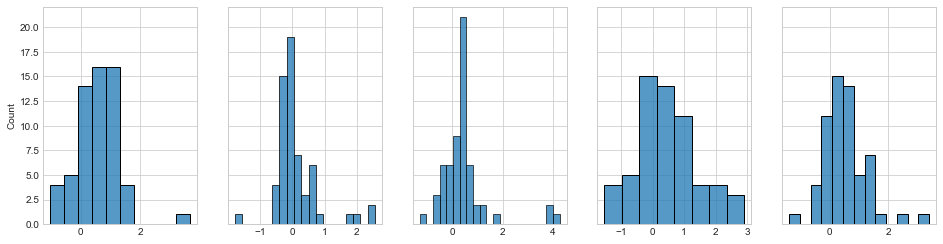

In [3]:
number_of_variables = 5

fig, axs = plt.subplots(1, number_of_variables, sharey=True, figsize=(16, 4))
for i in range(1, number_of_variables+1):
    sns.histplot(X[i], ax=axs[i-1])

## Model Training

We shuffle the rows to avoid a given ordering and perform a train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

### KNN

Lets have a look, how well the model performs for different k's:

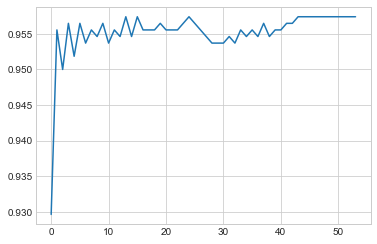

In [5]:
knn_scores = []
for k in range(1, 55):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    neigh.fit(X_train, y_train)
    knn_scores.append(neigh.score(X_test, y_test))
    
plt.plot(knn_scores)

Through 10-fold CV we get more reliable accuracies:

In [104]:
max_neighbors = 55
neighbors = range(5, max_neighbors+1, 5)

knn_scores = []
for k in neighbors:
    knn_cv = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    cv_scores = cross_val_score(knn_cv, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    knn_scores.append(avg_score)
    print(f"\r Step {k} / {max_neighbors} is done.", end="")
    
plt.plot(neighbors, knn_scores)

 Step 55 / 55 is done.

Orders?

In [111]:
max_neighbors = 55
neighbors = range(5, max_neighbors+1, 5)

orders = [1,2,3]

avg_scores_p = {}

for order in orders:
    avg_scores_p[order] = []
    for k in neighbors:
        knn_cv = KNeighborsClassifier(n_neighbors=k, p=order, metric='minkowski')
        cv_scores = cross_val_score(knn_cv, X, y, cv=3)
        avg_score = np.mean(cv_scores)
        avg_scores_p[order].append(avg_score)
        print(f"\r\r Order {order}: {k} / {max_neighbors}", end="")

for order in orders:
    plt.plot(neighbors, avg_scores_p[order])

 Order 3: 55 / 55

Can we improve the performance by adding distance wheights?

 Step 55 / 55 is done.

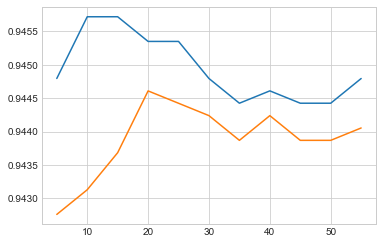

In [106]:
max_neighbors = 55
neighbors = range(5, max_neighbors+1, 5)

knn_scores_w = []
for k in neighbors:
    knn_cv = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, metric='minkowski')
    cv_scores = cross_val_score(knn_cv, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    knn_scores_w.append(avg_score)
    print(f"\r Step {k} / {max_neighbors} is done.", end="")

plt.plot(neighbors, knn_scores)
plt.plot(neighbors, knn_scores_w)

NO: Adding wheights does not improve the performance.

The performance is not quite satisfying yet. We have a lot of variables in our dataset. Maybe we can concentrate the information onto fewer variables through PCA:

 40 / 40

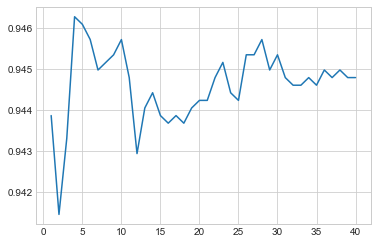

In [110]:
max_components = 40
components = range(1, max_components+1, 1)

knn_cv = KNeighborsClassifier(n_neighbors=12, weights="uniform", p=2, metric='minkowski')

knn_pca_scores = []
for comp in components:
    pca = PCA(n_components=comp, random_state=42)
    model = make_pipeline(pca, knn_cv)
    cv_scores = cross_val_score(model, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    knn_pca_scores.append(avg_score)
    print(f"\r {comp} / {max_components}", end="")
    
plt.plot(components, knn_pca_scores)

How many neighbors after PCA?

 Step 55 / 55 is done.

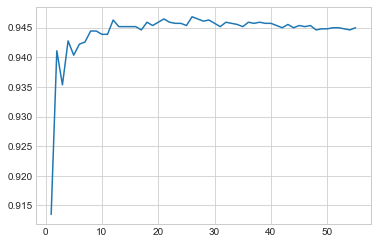

In [114]:
max_neighbors = 55
neighbors = range(1, max_neighbors+1, 1)

pca = PCA(n_components=4, random_state=42)

knn_pca_scores_n = []
for k in neighbors:
    knn_cv = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    model = make_pipeline(pca, knn_cv)
    cv_scores = cross_val_score(model, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    knn_pca_scores_n.append(avg_score)
    print(f"\r Step {k} / {max_neighbors} is done.", end="")
    
plt.plot(neighbors, knn_pca_scores_n)

n_components = [4 - 35]
n_neighbors = [5 - 30]
p = [1,2]
weights = ["uniform", "distance"]

## Random Forest

In [115]:
max_estimators = 600
estimators = range(50, max_estimators+1, 50)

rf_scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=3)
    avg_score = np.mean(cv_scores)
    rf_scores.append(avg_score)
    print(f"\r {k} / {max_estimators}", end="")
    
plt.plot(estimators, rf_scores)

 600 / 600

 400 / 400

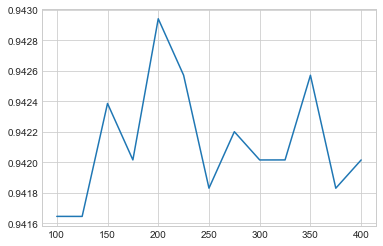

In [116]:
max_estimators = 400
estimators = range(100, max_estimators+1, 25)

rf_scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=3)
    avg_score = np.mean(cv_scores)
    rf_scores.append(avg_score)
    print(f"\r {k} / {max_estimators}", end="")
    
plt.plot(estimators, rf_scores)

In [117]:
max_depth = 50
depths = range(10, max_depth+1, 10)

rf_scores_depth = []
for k in depths:
    rf = RandomForestClassifier(n_estimators = 200, max_depth=k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=3)
    avg_score = np.mean(cv_scores)
    rf_scores_depth.append(avg_score)
    print(f"\r {k} / {max_depth}", end="")
    
plt.plot(depths, rf_scores_depth)

 50 / 50

 30 / 30

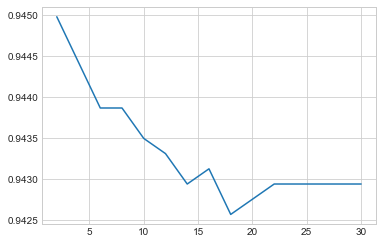

In [119]:
max_depth = 30
depths = range(2, max_depth+1, 2)

rf_scores_depth = []
for k in depths:
    rf = RandomForestClassifier(n_estimators = 200, max_depth=k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=3)
    avg_score = np.mean(cv_scores)
    rf_scores_depth.append(avg_score)
    print(f"\r {k} / {max_depth}", end="")
    
plt.plot(depths, rf_scores_depth)

 5 / 5

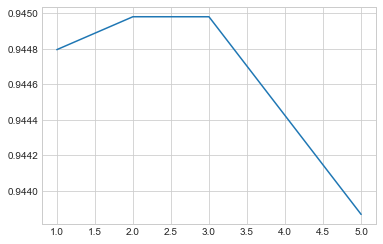

In [120]:
max_depth = 5
depths = range(1, max_depth+1, 1)

rf_scores_depth = []
for k in depths:
    rf = RandomForestClassifier(n_estimators = 200, max_depth=k, random_state = 42)
    cv_scores = cross_val_score(rf, X, y, cv=3)
    avg_score = np.mean(cv_scores)
    rf_scores_depth.append(avg_score)
    print(f"\r {k} / {max_depth}", end="")
    
plt.plot(depths, rf_scores_depth)

In [121]:
max_estimators = 400
estimators = range(100, max_estimators+1, 20)

criterions = ["entropy", "gini"]

scores_c = {}

for crit in criterions:
    scores_c[crit] = []
    for k in estimators:
        rf = RandomForestClassifier(n_estimators = k, criterion=crit, max_depth=3, random_state = 42)
        cv_scores = cross_val_score(rf, X, y, cv=10)
        avg_score = np.mean(cv_scores)
        scores_c[crit].append(avg_score)
        print(f"\r\r Criterion '{crit}': {k} / {max_estimators}                ", end="")

for crit in criterions:
    plt.plot(estimators, scores_c[crit])

 Criterion 'gini': 400 / 400400

In [6]:
max_components = 20
components = range(2, max_components+1, 2)

rf = RandomForestClassifier(n_estimators = 200, random_state = 42)

rf_scores_pca = []
for comp in components:
    pca = PCA(n_components=comp, random_state=42)
    model = make_pipeline(pca, rf)
    cv_scores = cross_val_score(model, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    rf_scores_pca.append(avg_score)
    print(f"\r {comp} / {max_components}", end="")
    
plt.plot(components, rf_scores_pca)

 20 / 20

 400 / 400

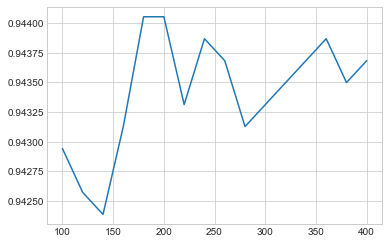

In [7]:
max_estimators = 400
estimators = range(100, max_estimators+1, 20)

pca = PCA(n_components=10, random_state=42)

rf_pca_scores = []
for k in estimators:
    rf = RandomForestClassifier(n_estimators = k, random_state = 42)
    model = make_pipeline(pca, rf)
    cv_scores = cross_val_score(model, X, y, cv=10)
    avg_score = np.mean(cv_scores)
    rf_pca_scores.append(avg_score)
    print(f"\r {k} / {max_estimators}", end="")
    
plt.plot(estimators, rf_pca_scores)

## SVM

In [ ]:
kernels = [ "linear", "poly", "rbf", "sigmoid"]

svm_scores = []
for kern in kernels:
    svm = SVC(kernel=kern, random_state = 42)
    cv_scores = cross_val_score(svm, X, y, cv=5, verbose=2)
    avg_score = np.mean(cv_scores)
    svm_scores.append(avg_score)
    print(f"\r{kern} / {kernels}             ", end="")

plt.plot(kernels, svm_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
max_C = 100
cs = np.geomspace(0.1, max_C, 10)

svm_scores_c = []
for c in cs:
    svm = SVC(C=c, kernel="linear", random_state = 42)
    cv_scores = cross_val_score(svm, X, y, cv=5)
    avg_score = np.mean(cv_scores)
    svm_scores_c.append(avg_score)
    print(f"\r{c} / {max_C}                 ", end="")

plt.plot(cs, svm_scores_c)

In [8]:
max_C = 2
cs = np.linspace(0.1, max_C, 20)

svm_scores_c = []
for c in cs:
    svm = SVC(C=c, kernel="rbf", random_state = 42)
    cv_scores = cross_val_score(svm, X, y, cv=5)
    avg_score = np.mean(cv_scores)
    svm_scores_c.append(avg_score)
    print(f"\r{c} / {max_C}                 ", end="")

plt.plot(cs, svm_scores_c)

2.0 / 2                                

2.0 / 2                                

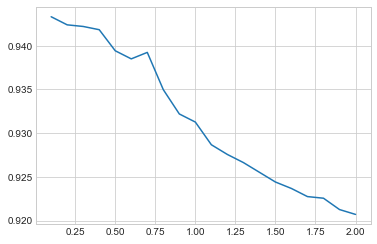

In [9]:
max_C = 2
cs = np.linspace(0.1, max_C, 20)

svm_scores_c = []
for c in cs:
    svm = SVC(C=c, kernel="sigmoid", random_state = 42)
    cv_scores = cross_val_score(svm, X, y, cv=5)
    avg_score = np.mean(cv_scores)
    svm_scores_c.append(avg_score)
    print(f"\r{c} / {max_C}                 ", end="")

plt.plot(cs, svm_scores_c)